# Examine SRlite stability across overlapping scenes at pseudo-invariant calibration sites
### Create a time series of SR values at selected points

In [132]:
import geopandas
import pandas as pd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from shapely.geometry import Point
import glob
import numpy as np
from shapely.geometry import Point, Polygon
from datetime import datetime
import os
import pyproj

!pip install mizani

import plotnine
from plotnine import * 
from mizani.breaks import date_breaks
from mizani.formatters import date_format

import matplotlib.pyplot as plt

import sys
sys.path.append('/home/pmontesa/code/geoscitools')
import maplib
import footprintlib

import contextily as ctx
from contextily.tile import warp_img_transform, warp_tiles, _warper

Defaulting to user installation because normal site-packages is not writeable


Functions to generate random points

In [2]:
def Random_Points_in_Bounds(polygon, number):   
    minx, miny, maxx, maxy = polygon.bounds
    x = np.random.uniform( minx, maxx, number )
    y = np.random.uniform( miny, maxy, number )
    return x, y

def get_random_points_in_bounds(rio_dataset, n_points=100):
    '''Return a gdf of a set of n random points within a rasterio dataset's bounds
    https://www.matecdev.com/posts/random-points-in-polygon.html
    '''
    # Get crs for raster
    raster_proj = pyproj.Proj(rio_dataset.crs)
    
    # Create shapely polygon from raster bounds
    from shapely.geometry import box
    geom = box(*rio_dataset.bounds)
    gdf_poly = geopandas.GeoDataFrame(index=[rio_dataset.name], geometry=[geom], crs=rio_dataset.crs)
    gdf_poly['name'] = os.path.basename(rio_dataset.name)
    #print(gdf_poly)
    #ax=gdf_poly.plot()

    x,y = Random_Points_in_Bounds(geom, n_points)
    
    # Convert to lon,lat
    inProj = pyproj.Proj(rio_dataset.crs)
    outProj = pyproj.Proj(init='epsg:4326')
    lon, lat = pyproj.transform(inProj, outProj, x, y)
    
    df = pd.DataFrame()
    df['points'] = list(zip(x,y))
    df["lon"] = lon
    df["lat"] = lat
    df['geometry'] = df['points'].apply(Point)
    df['site'] = df.index + 1
    df['crs'] = raster_proj
    
    gdf_points = geopandas.GeoDataFrame(df, geometry='geometry', crs=rio_dataset.crs)
    #gdf_points.plot(ax=ax, color='red')
    
    return gdf_points, gdf_poly

Function to extract the raster values for points in the gdf

In [70]:
df_sr = get_ref_timeseries_table(gdf_random_points, f_list, batchname=BATCHNAME, DO_4BAND=False)

['BAND_B', 'BAND_G', 'BAND_R', 'BAND_N']
['BAND_B', 'BAND_G', 'BAND_R', 'BAND_N']
['BAND_C', 'BAND_B', 'BAND_G', 'BAND_Y', 'BAND_R', 'BAND_RE', 'BAND_N', 'BAND_N2']
['BAND_B', 'BAND_G', 'BAND_R', 'BAND_N']


In [115]:
#band_names_list = ['BAND_C', 'BAND_B', 'BAND_G', 'BAND_Y', 'BAND_R', 'BAND_RE', 'BAND_N', 'BAND_N2']
def plot_timeseries(df, BANDSLIST = ["BAND_B","BAND_G","BAND_R","BAND_N"], YLIMS = (0.20,0.75), DO_NAMES = True):
    
    df.m = pd.melt(df, id_vars=["site","geometry","batchname","name","date","year",'sensor','lon','lat','type_ref'], value_vars=BANDSLIST)
    
    # Use dropna() to ensure all points in time are connected with a line
    p = (
        ggplot(df.m.dropna(), aes(x="date", y='value', color='variable', group='variable', linetype='sensor', shape="sensor"))
        + labs(title='Time-series at sites', y='Reflectance', x=None)
        + geom_point(size=2)
        + geom_line()
        #+ geom_text(aes(label='name'), angle=90, size=5)
        + scale_color_manual(values = ('dodgerblue', 'limegreen', 'indigo', 'red'), name='Band')
        + scale_x_datetime(breaks=date_breaks('3 months'), labels=date_format('%Y %b-%d'))        # new
        + coord_cartesian(ylim = YLIMS)
        + theme_bw()
        + theme(axis_text_x = element_text(rotation=90, size=8), strip_text_x = element_text(size=14), strip_text_y = element_text(size=6))
        + facet_grid('site+lon+lat ~ type_ref+batchname')

    )
    if DO_NAMES:
        p = p + geom_text(aes(label='name'), angle=90, size=5)
    return p

def get_ref_timeseries_table(gdf, f_list, batchname=None, DO_4BAND=True, RM_LIST = ["BAND_C","BAND_Y","BAND_RE","BAND_N2"], NODATA_VAL = -9999, REF_SCALE_FACTOR = 10000.0):
    
    '''Get a timeseries data frame of reflectance (SR, TOA) band values for a gdf of (random?) points for a list of rasters'''
    
    # A list of all the points (sites) with each SR value of each raster
    data_qb, data_wv, data_wv8band, data_ge = [], [], [], []
    bandnames_list_qb02, bandnames_list_wv, bandnames_list_wv8band, bandnames_list_ge = [],[],[],[]

    df_list = []
    
    # Loop over list of rasters from a glob of an SRlite output batch dir
    for i, fpath in enumerate(f_list):

        with rasterio.open(fpath) as src:
            
            # Discover the band names by file
            # Clean up band names in raster
            bandnames_list = [b.replace('-','_') for b in list(src.descriptions)]
            #print(bandnames_list)
            # Use the gdf to get site coords and name
            coord_list = [(x,y,site,lon,lat) for x,y,site,lon,lat in zip(gdf['geometry'].x , gdf['geometry'].y, gdf['site'], gdf['lon'], gdf['lat'])]
            
           #  Use site coords and name to sample raster and add to data
            for i,n in enumerate(coord_list):

                coord_list_site = [coord_list[i][0:2]]
                #print(coord_list_site)
                site_name = coord_list[i][2]
                lon = round(coord_list[i][3], 6)
                lat = round(coord_list[i][4], 6)
                #print(site_name)
                # Sample the reflectance values for each band at each point
                reflectance_list = [x/REF_SCALE_FACTOR for x in src.sample(coord_list_site)]
                list_reflectance_data_row = [item for sublist in reflectance_list for item in sublist]
                
                # If you have only 4 band data to begin with, set DO_4BAND
                #if len(list_reflectance_data_row) == 4:
                #    DO_4BAND = True
                #else:
                #    DO_4BAND = False
                    
                if DO_4BAND:
                    #all_BANDS_list = ['BAND_C', 'BAND_B', 'BAND_G', 'BAND_Y', 'BAND_R', 'BAND_RE', 'BAND_N', 'BAND_N2']
                    idx_4BAND = [bandnames_list.index(x) for x in bandnames_list if x not in RM_LIST]
                    # Get just the data that corresponds to the 4BAND data
                    list_reflectance_data_row = [list_reflectance_data_row[i] for i in idx_4BAND]
                #print(len(list_reflectance_data_row))
                    

                # Get image info: sensor, name, and date
                name = os.path.basename(fpath).split('-')[0]
                sensor = name.split('_')[0]
                datestring = name.split('_')[1]
                #print(datestring)
                
                # Append the current site's data to the correct sensor data list
                site_data = [site_name] + [lon] + [lat] + [coord_list_site] + [batchname] + [sensor] + [name] + [datestring] + list_reflectance_data_row
                    
                if 'QB02' in fpath:
                    data_qb.append(site_data)
                    bandnames_list_qb02 = bandnames_list
                    SENSOR_CLASS = 'QB'
                if 'WV0' in fpath:
                    if len(bandnames_list) == 8:
                        data_wv8band.append(site_data)
                        bandnames_list_wv8band = bandnames_list 
                        data_wv8band.append(site_data)
                    else:
                        data_wv.append(site_data)
                        bandnames_list_wv = bandnames_list
                        data_wv.append(site_data)
                    bandnames_list_wv = bandnames_list
                    SENSOR_CLASS = 'WV'
                if 'GE01' in fpath:
                    data_ge.append(site_data)
                    bandnames_list_ge = bandnames_list
                    SENSOR_CLASS = 'GE'
        #print(SENSOR_CLASS)
                # Append the current site's data
                #data.append([site_name] + \
                #                [lon] + [lat] + 
                #                [coord_list_site] + \
                #                #[inProj] + 
                #                [batchname] + [sensor] + [name] + [datestring] + [item for sublist in reflectance_list for item in sublist])
                
    for i, data in enumerate([data_qb, data_wv, data_wv8band, data_ge]):
        if len(data) > 0:
            #print(data)
            bandnames_list = [bandnames_list_qb02, bandnames_list_wv, bandnames_list_wv8band, bandnames_list_ge][i] 
            
            if DO_4BAND:
                # Just drop the extra WV02 band names for now..
                bandnames_list = [b for b in bandnames_list if b not in RM_LIST]
            print(bandnames_list)
            #print(pd.DataFrame(data).info())
            df = pd.DataFrame(data, columns = ['site'] + ['lon', 'lat'] + ['geometry'] + ['batchname','sensor','name', 'date'] + bandnames_list).replace(NODATA_VAL/REF_SCALE_FACTOR, np.nan)
            df['date'] = pd.to_datetime(df['date'], format="%Y%m%d")
            df['year'] = df['date'].dt.year
            #print(df)
            df_list.append(df)
    df = pd.concat(df_list, axis=0, ignore_index=True)
    return df
    

Make a list of rasters for the time-series

In [121]:
MAIN_DIR = '/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.14-10132022-csv-8band/10132022'
DICT_BATCH_WHITESANDS = {
    #'f_list': glob.glob('/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.13-08012022-GLAD-ARD/09192022/Whitesands/*sr-02m.tif'),
    'f_list': glob.glob(f'{MAIN_DIR}/Whitesands/*sr-02m.tif'),
    'f_toa_list': glob.glob('/explore/nobackup/projects/ilab/data/srlite/toa/Whitesands/*M1BS*toa.tif'),
    'batchname': 'White Sands, NM',
    'target_catid': '1010010009F6C100'
}
DICT_BATCH_RRValley = {
    'f_list': glob.glob(f'{MAIN_DIR}/RailroadValley/*sr-02m.tif'),
    'f_toa_list': glob.glob('/explore/nobackup/projects/ilab/data/srlite/toa/RailroadValley/*M1BS*toa.tif'),
    'batchname': 'RailroadValley, CO',
    'target_catid': '104001001EBCCC00'
}
DICT_BATCH_ALASKA = {
    'f_list': glob.glob(f'{MAIN_DIR}/Alaska/*sr-02m.tif'),
    'f_toa_list': glob.glob('/explore/nobackup/projects/ilab/data/srlite/toa/Alaska/*M1BS*toa.tif'),
    'batchname': 'Alaska',
    'target_catid': '10300100265B2000'
}
DICT_BATCH_SIBERIA = {
    'f_list': glob.glob(f'{MAIN_DIR}/Siberia/*sr-02m.tif'),
    'f_toa_list': glob.glob('/explore/nobackup/projects/ilab/data/srlite/toa/Siberia/*M1BS*toa.tif'),
    'batchname': 'Siberia',
    'target_catid': '10300100223FD400'
}

In [122]:
SELECTED_DICT = DICT_BATCH_ALASKA
f_list = SELECTED_DICT['f_list']
f_toa_list = SELECTED_DICT['f_toa_list']
BATCHNAME = SELECTED_DICT['batchname']

print(len(f_list))
f_list

63


['/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.14-10132022-csv-8band/10132022/Alaska/GE01_20200621_M1BS_105001001E0F7000-sr-02m.tif',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.14-10132022-csv-8band/10132022/Alaska/GE01_20200621_M1BS_105001001E0F7100-sr-02m.tif',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.14-10132022-csv-8band/10132022/Alaska/GE01_20140705_M1BS_1050410010CD1600-sr-02m.tif',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.14-10132022-csv-8band/10132022/Alaska/GE01_20200620_M1BS_105001001E0B2E00-sr-02m.tif',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.14-10132022-csv-8band/10132022/Alaska/GE01_20200621_M1BS_105001001E0F6F00-sr-02m.tif',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.14-10132022-csv-8band/10132022/Alaska/GE01_20150731_M1BS_1050010001163300-sr-02m.tif',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.14-10132022-csv-

## Get all footprints of data in list

In [148]:
import contextily as ctx
from contextily.tile import warp_img_transform, warp_tiles, _warper

Building GDF from list...


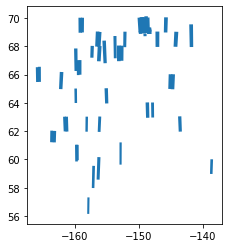

In [154]:
f_gdf_lst = [footprintlib.raster_footprint(r_fn, DO_DATAMASK=False, GET_ONLY_DATASETMASK=True, R_READ_MODE='r', MANY_CRS=True) for r_fn in f_list]
footprint_gdf = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME=BATCHNAME, DROP_DUPLICATES=True)



In [157]:
ctx.providers

{'OpenStreetMap': {'Mapnik': {'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.Mapnik'},
  'DE': {'url': 'https://{s}.tile.openstreetmap.de/tiles/osmde/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.DE'},
  'CH': {'url': 'https://tile.osm.ch/switzerland/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'bounds': [[45, 5], [48, 11]],
   'name': 'OpenStreetMap.CH'},
  'France': {'url': 'https://{s}.tile.openstreetmap.fr/osmfr/{z}/{x}/{y}.png',
   'max_zoom': 20,
   'html_attribution': '&copy; OpenStreetMap France | &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap France | (C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.France'},
  'HOT': {'url': 'https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles style by <a href="https://www.hotosm.org/" target="_blank">Humanitarian OpenStreetMap Team</a> hosted by <a href="https://openstreetmap.fr/" target="_blank">OpenStreetMap France</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by OpenStreetMap France',
   'name': 'OpenStreetMap.HOT'},
  'BZH': {'url': 'https://tile.openstreetmap.bzh/br/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles courtesy of <a href="http://www.openstreetmap.bzh/" target="_blank">Breton OpenStreetMap Team</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles courtesy of Breton OpenStreetMap Team',
   'bounds': [[46.2, -5.5], [50, 0.7]],
   'name': 'OpenStreetMap.BZH'},
  'BlackAndWhite': {'url': 'http://{s}.tiles.wmflabs.org/bw-mapnik/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'attribution': '(C) OpenStreetMap contributors',
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'name': 'OpenStreetMap.BlackAndWhite'}},
 'OpenSeaMap': {'url': 'https://tiles.openseamap.org/seamark/{z}/{x}/{y}.png',
  'html_attribution': 'Map data: &copy; <a href="http://www.openseamap.org">OpenSeaMap</a> contributors',
  'attribution': 'Map data: (C) OpenSeaMap contributors',
  'name': 'OpenSeaMap'},
 'OPNVKarte': {'url': 'https://tileserver.memomaps.de/tilegen/{z}/{x}/{y}.png',
  'max_zoom': 18,
  'html_attribution': 'Map <a href="https://memomaps.de/">memomaps.de</a> <a href="http://creativecommons.org/licenses/by-sa/2.0/">CC-BY-SA</a>, map data &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
  'attribution': 'Map memomaps.de CC-BY-SA, map data (C) OpenStreetMap contributors',
  'name': 'OPNVKarte'},
 'OpenTopoMap': {'url': 'https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png',
  'max_zoom': 17,
  'html_attribution': 'Map data: &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, <a href="http://viewfinderpanoramas.org">SRTM</a> | Map style: &copy; <a href="https://opentopomap.org">OpenTopoMap</a> (<a href="https://creativecommons.org/licenses/by-sa/3.0/">CC-BY-SA</a>)',
  'attribution': 'Map data: (C) OpenStreetMap contributors, SRTM | Map style: (C) OpenTopoMap (CC-BY-SA)',
  'name': 'OpenTopoMap'},
 'OpenRailwayMap': {'url': 'https://{s}.tiles.openrailwaymap.org/standard/{z}/{x}/{y}.png',
  'max_

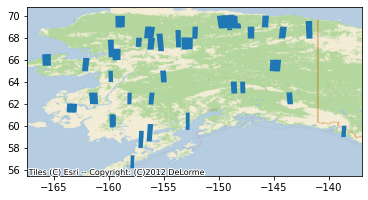

In [176]:
ax = footprint_gdf.plot()
ctx.add_basemap(ax, crs=4326, 
    #source = ctx.providers.Gaode.Satellite
    #source = ctx.providers.Esri.WorldShadedRelief
    #source = ctx.providers.Esri.WorldGrayCanvas
    #source = ctx.providers.Esri.NatGeoWorldMap
    #source = ctx.providers.Esri.WorldImagery
    source = ctx.providers.Esri.DeLorme
)

Choose a raster source for the bounds in which random points will be generated

In [123]:
fn_of_selected_catid = [i for i in SELECTED_DICT['f_list'] if SELECTED_DICT['target_catid'] in i][0]
src = rasterio.open(fn_of_selected_catid)
gdf_random_points, gdf_bounding_polygon = get_random_points_in_bounds(src, n_points=10)

/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages/pyproj/crs/crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


# Map the site and random points

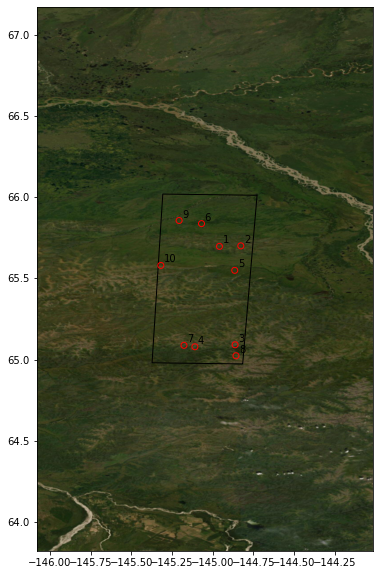

In [124]:
ax = gdf_bounding_polygon.to_crs(4326).plot(figsize=(10, 10), edgecolor='black', color='none')
ax = gdf_random_points.to_crs(4326).plot(ax=ax, edgecolor='red', color='none')
for x, y, label in zip(gdf_random_points.lon, gdf_random_points.lat, gdf_random_points.site):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
plt.margins(y=1.1, x=1.1)
#ctx.add_basemap(ax,  source='https://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/tile/{z}/{y}/{x}', crs=4326)
ctx.add_basemap(ax, source='https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', crs=4326)


In [125]:
gdf_random_points

,points,lon,lat,geometry,site,crs
0,"(593753.5855860242, 7287732.041574223)",-144.958188,65.697645,POINT (593753.586 7287732.042),1,proj=utm zone=6 datum=WGS84 units=m no_defs el...
1,"(599773.7108725655, 7288299.224853044)",-144.826763,65.700920,POINT (599773.711 7288299.225),2,proj=utm zone=6 datum=WGS84 units=m no_defs el...
2,"(600467.4040454361, 7220442.493473031)",-144.861797,65.092306,POINT (600467.404 7220442.493),3,proj=utm zone=6 datum=WGS84 units=m no_defs el...
3,"(588888.9849184813, 7218700.588102165)",-145.109151,65.079998,POINT (588888.985 7218700.588),4,proj=utm zone=6 datum=WGS84 units=m no_defs el...
4,"(598632.1753067249, 7271443.87918805)",-144.864068,65.550151,POINT (598632.175 7271443.879),5,proj=utm zone=6 datum=WGS84 units=m no_defs el...
5,"(588208.5761867663, 7303173.3557808325)",-145.068529,65.837672,POINT (588208.576 7303173.356),6,proj=utm zone=6 datum=WGS84 units=m no_defs el...
6,"(585706.2658599828, 7219583.747975173)",-145.176269,65.088758,POINT (585706.266 7219583.748),7,proj=utm zone=6 datum=WGS84 units=m no_defs el...
7,"(600979.6901673323, 7212930.661036897)",-144.856325,65.024796,POINT (600979.690 7212930.661),8,proj=utm zone=6 datum=WGS84 units=m no_defs el...
8,"(581855.1935156072, 7305114.79928618)",-145.206346,65.856771,POINT (581855.194 7305114.799),9,proj=utm zone=6 datum=WGS84 units=m no_defs el...
9,"(577548.0564056654, 7274184.113128546)",-145.318799,65.580459,POINT (577548.056 7274184.113),10,proj=utm zone=6 datum=WGS84 units=m no_defs el...


In [126]:
m = maplib.MAP_LAYER_FOLIUM(LAYER=gdf_bounding_polygon.to_crs(3857), LAYER_COL_NAME='name', lat_start=gdf_bounding_polygon.to_crs(4326).geometry.centroid.y, lon_start=gdf_bounding_polygon.to_crs(4326).geometry.centroid.x)
maplib.ADD_POINT_OBS_TO_MAP(gdf_random_points.to_crs(3857) ,foliumMap=m)
#maplib.MAP_LAYER_FOLIUM(LAYER=gdf_random_points[["geometry", "site"]].to_crs(3857), LAYER_COL_NAME='site', foliumMap=m)

/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



# Run the extraction function, return a time-series dataframe, plot

In [10]:
plotnine.options.figure_size = (18, 10)
# https://stackoverflow.com/questions/20571306/multi-row-x-axis-labels-in-ggplot-line-chart

In [127]:
df_sr = get_ref_timeseries_table(gdf_random_points, f_list, batchname=BATCHNAME, DO_4BAND = False)
df_sr['type_ref'] = 'SR'

['BAND_B', 'BAND_G', 'BAND_R', 'BAND_N']
['BAND_B', 'BAND_G', 'BAND_R', 'BAND_N']
['BAND_C', 'BAND_B', 'BAND_G', 'BAND_Y', 'BAND_R', 'BAND_RE', 'BAND_N', 'BAND_N2']
['BAND_B', 'BAND_G', 'BAND_R', 'BAND_N']


In [128]:
df_toa = get_ref_timeseries_table(gdf_random_points, f_toa_list, batchname=BATCHNAME, DO_4BAND = True)
df_toa['type_ref'] = 'TOA'

['BAND_B', 'BAND_G', 'BAND_R', 'BAND_N']
['BAND_B', 'BAND_G', 'BAND_R', 'BAND_N']
['BAND_B', 'BAND_G', 'BAND_R', 'BAND_N']
['BAND_B', 'BAND_G', 'BAND_R', 'BAND_N']


In [112]:
df_toa

,site,lon,lat,geometry,batchname,sensor,name,date,BAND_B,BAND_G,BAND_R,BAND_N,year,type_ref
0,1,-149.772500,69.304224,"[(390682.0443750515, 7690759.935095853)]",Alaska,QB02,QB02_20100606_M1BS_101001000BC80E00,2010-06-06,NaN,NaN,NaN,NaN,2010,TOA
1,2,-149.596009,69.517703,"[(398646.87035673886, 7714241.453053968)]",Alaska,QB02,QB02_20100606_M1BS_101001000BC80E00,2010-06-06,NaN,NaN,NaN,NaN,2010,TOA
2,3,-149.591956,69.829014,"[(400277.5721479597, 7748923.124192788)]",Alaska,QB02,QB02_20100606_M1BS_101001000BC80E00,2010-06-06,NaN,NaN,NaN,NaN,2010,TOA
3,4,-149.587707,69.171067,"[(397337.4955867837, 7675604.372132726)]",Alaska,QB02,QB02_20100606_M1BS_101001000BC80E00,2010-06-06,NaN,NaN,NaN,NaN,2010,TOA
4,5,-149.907984,69.208240,"[(384835.42907354573, 7680315.027378345)]",Alaska,QB02,QB02_20100606_M1BS_101001000BC80E00,2010-06-06,NaN,NaN,NaN,NaN,2010,TOA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,6,-149.593778,69.448693,"[(398407.69589852035, 7706548.383683438)]",Alaska,GE01,GE01_20180907_M1BS_1050010012146100,2018-09-07,NaN,NaN,NaN,NaN,2018,TOA
3216,7,-150.126046,69.975116,"[(380577.9887336563, 7766159.95727383)]",Alaska,GE01,GE01_20180907_M1BS_1050010012146100,2018-09-07,NaN,NaN,NaN,NaN,2018,TOA
3217,8,-149.724790,69.268117,"[(392383.0891682478, 7686652.638791128)]",Alaska,GE01,GE01_20180907_M1BS_1050010012146100,2018-09-07,NaN,NaN,NaN,NaN,2018,TOA
3218,9,-149.853997,69.345609,"[(387685.6813282589, 7695518.063486372)]",Alaska,GE01,GE01_20180907_M1BS_1050010012146100,2018-09-07,NaN,NaN,NaN,NaN,2018,TOA


In [129]:
g = df_toa.dropna().groupby('name')
list(g.groups)

['WV02_20130812_M1BS_1030010025945F00', 'WV02_20130812_M1BS_10300100265B2000']

# Plot time-series

/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


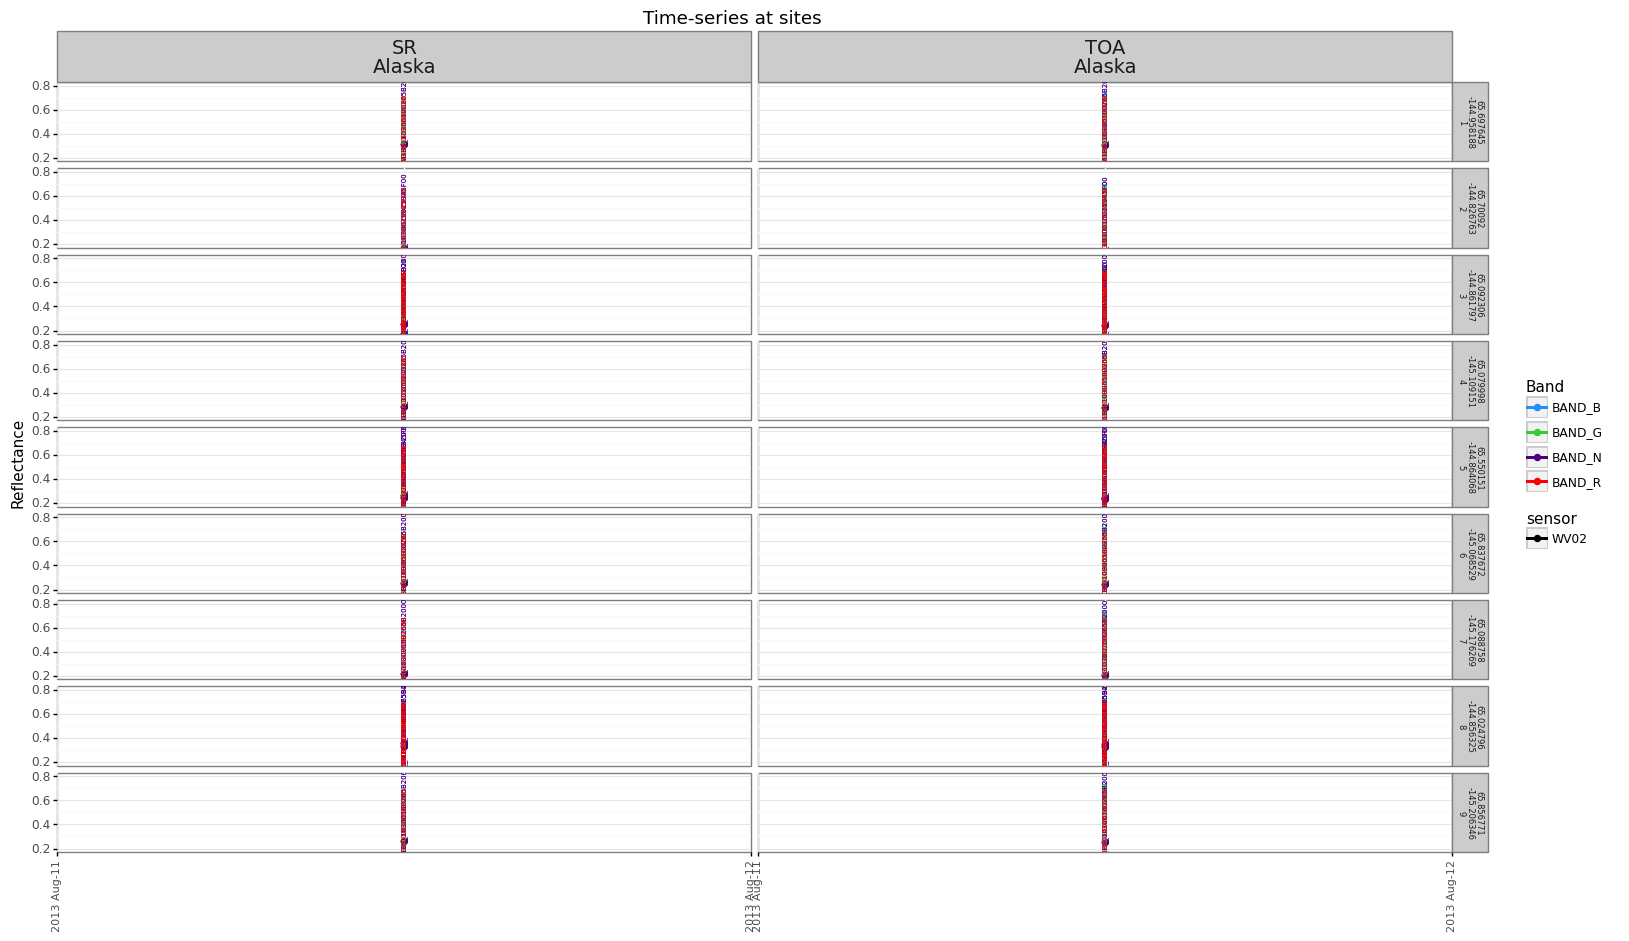

<ggplot: (2963449597613)>

In [130]:
plot_timeseries(pd.concat([df_sr,df_toa]), YLIMS = (0.20,0.8))

#
#
#
# Scratch

/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages/pyproj/crs/crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


[(372053.0, 3641365.0)]
20020914
[(372053.0, 3641365.0)]
20021020
[(372053.0, 3641365.0)]
20030730
[(372053.0, 3641365.0)]
20061028
[(372053.0, 3641365.0)]
20070108
[(372053.0, 3641365.0)]
20070604
[(372053.0, 3641365.0)]
20081213
[(372053.0, 3641365.0)]
20090720
[(372053.0, 3641365.0)]
20101114
[(372053.0, 3641365.0)]
20120915
[(372053.0, 3641365.0)]
20130302
[(372053.0, 3641365.0)]
20130812
[(372053.0, 3641365.0)]
20131223
[(372053.0, 3641365.0)]
20150501
[(372053.0, 3641365.0)]
20150911


,site_name,lon,lat,geometry,src_crs,name,date,BAND_B,BAND_G,BAND_R,BAND_N
0,site_1,-106.368101,32.903014,"(372053.0, 3641365.0)",proj=utm zone=13 datum=WGS84 units=m no_defs e...,QB02_20020914_M1BS_10100100012C3E00-sr-02m.tif,2002-09-14,0.6947,0.4689,0.5589,0.5538
1,site_1,-106.368101,32.903014,"(372053.0, 3641365.0)",proj=utm zone=13 datum=WGS84 units=m no_defs e...,QB02_20021020_M1BS_1010010001594B00-sr-02m.tif,2002-10-20,0.4809,0.4651,0.5286,0.5606
2,site_1,-106.368101,32.903014,"(372053.0, 3641365.0)",proj=utm zone=13 datum=WGS84 units=m no_defs e...,QB02_20030730_M1BS_1010010002264900-sr-02m.tif,2003-07-30,0.7185,0.4374,0.4862,0.5209
3,site_1,-106.368101,32.903014,"(372053.0, 3641365.0)",proj=utm zone=13 datum=WGS84 units=m no_defs e...,QB02_20061028_M1BS_101001000548E800-sr-02m.tif,2006-10-28,0.4032,0.4489,0.5027,0.5441
4,site_1,-106.368101,32.903014,"(372053.0, 3641365.0)",proj=utm zone=13 datum=WGS84 units=m no_defs e...,QB02_20070108_M1BS_10100100056A6900-sr-02m.tif,2007-01-08,0.3973,0.4804,0.5444,0.5783
5,site_1,-106.368101,32.903014,"(372053.0, 3641365.0)",proj=utm zone=13 datum=WGS84 units=m no_defs e...,QB02_20070604_M1BS_1010010005AA7100-sr-02m.tif,2007-06-04,0.9434,0.5558,0.7359,0.6140
6,site_1,-106.368101,32.903014,"(372053.0, 3641365.0)",proj=utm zone=13 datum=WGS84 units=m no_defs e...,QB02_20081213_M1BS_1010010008EAEB00-sr-02m.tif,2008-12-13,0.4503,0.5287,0.5926,0.6083
7,site_1,-106.368101,32.903014,"(372053.0, 3641365.0)",proj=utm zone=13 datum=WGS84 units=m no_defs e...,QB02_20090720_M1BS_1010010009F6C100-sr-02m.tif,2009-07-20,0.8864,0.5329,0.7265,0.6155
8,site_1,-106.368101,32.903014,"(372053.0, 3641365.0)",proj=utm zone=13 datum=WGS84 units=m no_defs e...,WV02_20101114_M1BS_10300100075B3D00-sr-02m.tif,2010-11-14,NaN,NaN,NaN,NaN
9,site_1,-106.368101,32.903014,"(372053.0, 3641365.0)",proj=utm zone=13 datum=WGS84 units=m no_defs e...,WV02_20120915_M1BS_103001001BC7D300-sr-02m.tif,2012-09-15,0.6404,0.5290,0.7265,0.6142


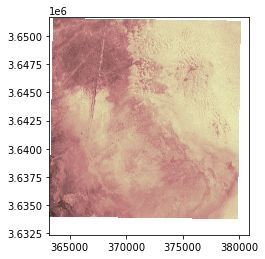

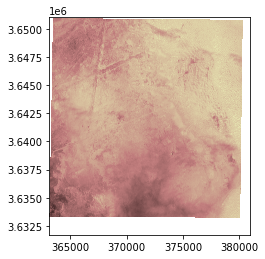

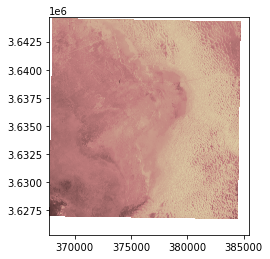

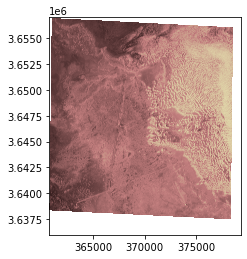

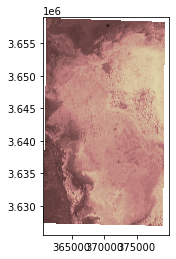

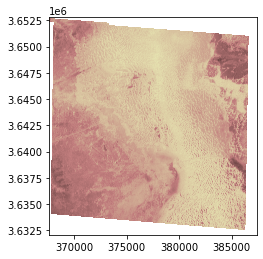

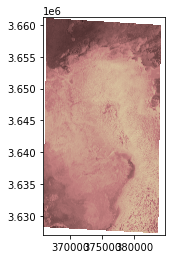

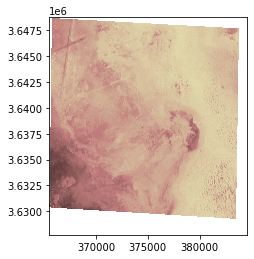

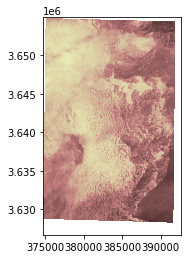

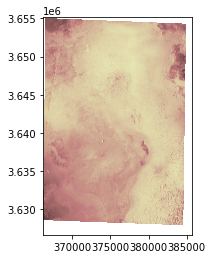

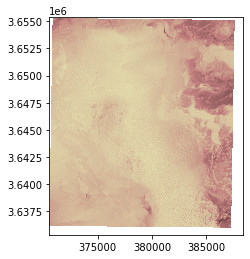

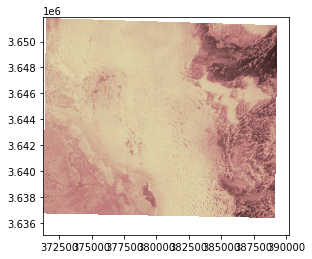

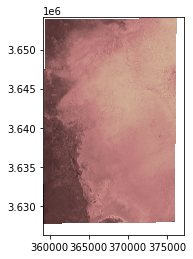

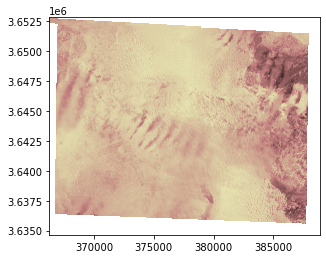

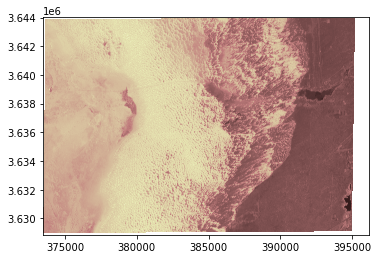

In [12]:
# x_mid, y_mid = [np.mean(extent[0:2]), np.mean(extent[2:4])]
x_mid, y_mid = [372053.0, 3641365.0]

# Create sampling points in lat/lon
points = [Point(x_mid, y_mid)]

inProj = pyproj.Proj(src.crs)
outProj = pyproj.Proj(init='epsg:4326')

lon, lat = pyproj.transform(inProj,outProj,x_mid, y_mid)

# Create sampling points in lat/lon
points = [Point(x_mid, y_mid)]
gdf = geopandas.GeoDataFrame(['site_1'], columns=['site_name'], geometry=points, crs=src.crs)
#print(gdf)
data = []


for i, fpath in enumerate(f_list):
    
    src = rasterio.open(fpath)
    
    fig, ax = plt.subplots()

    # transform rasterio plot to real world coords
    extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
    ax = rasterio.plot.show(src, extent=extent, ax=ax, cmap='pink')
    
    bandnames_list = [b.replace('-','_') for b in list(src.descriptions)]
    
    # Sample all band at the point
    coord_list = [(x,y) for x,y in zip(gdf['geometry'].x , gdf['geometry'].y)]
    print(coord_list)
    reflectance_list = [x/10000. for x in src.sample(coord_list)]
    #print(reflectance_list)
    
    # Get scene name and date
    name = os.path.basename(fpath)
    datestring = name.split('_')[1]
    print(datestring)
    
    data.append([gdf.site_name.to_list()[0]] + [lon] + [lat] + coord_list + [inProj] + [name] + [datestring] + [item for sublist in reflectance_list for item in sublist])
        
df = pd.DataFrame(data, columns = ['site_name'] + ['lon', 'lat'] + ['geometry', 'src_crs', 'name', 'date'] + bandnames_list).replace(-0.9999, np.nan)
df['date'] = pd.to_datetime(df['date'], format="%Y%m%d")
df
#gdf = geopandas.GeoDataFrame(df, geometry=df.geometry, crs=src.crs)